In [5]:
import os
import sys

try:
    import pyproj
    proj_path = pyproj.datadir.get_data_dir()
    
   
    os.environ['PROJ_LIB'] = proj_path
    os.environ['PROJ_DATA'] = proj_path
    
    print(f"SUCCESS: Forced PROJ database path to: {proj_path}")
    
except ImportError:

    fallback_path = os.path.join(sys.prefix, 'Lib', 'site-packages', 'pyproj', 'proj_dir', 'share')
    os.environ['PROJ_LIB'] = fallback_path
    print(f"WARNING: Using fallback path: {fallback_path}")


import pystac_client
import planetary_computer
import odc.stac
import geopandas as gpd
import numpy as np
import rasterio 

print("Libraries imported successfully. Proceed to next cell.")

SUCCESS: Forced PROJ database path to: c:\Users\ajinp\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj
Libraries imported successfully. Proceed to next cell.


Load ROI and Set Base Directory here

In [ ]:
import os
import sys


try:
    import pyproj
    proj_path = pyproj.datadir.get_data_dir()
    os.environ['PROJ_LIB'] = proj_path
    print(f"SUCCESS: Fixed PROJ_LIB path to: {proj_path}")
except ImportError:
    print("Pyproj not found, attempting to continue...")
import pystac_client
import planetary_computer
import odc.stac
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rasterio
from rasterio.plot import show
import json

#####################   Define Paths   #######################################################
BASE_DIR = r"C:\Users\ajinp\OneDrive - University of Twente\Desktop\imagery-analyst-project"
DATA_DIR = os.path.join(BASE_DIR, "data")
OUTPUT_DIR = os.path.join(BASE_DIR, "output")

# Ensure Output Directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load ROI
roi_path = os.path.join(DATA_DIR, "roi.geojson")
gdf = gpd.read_file(roi_path)
bbox = gdf.total_bounds 

print(f"Environment Ready. ROI Loaded: {bbox}")

SUCCESS: Fixed PROJ_LIB path to: c:\Users\ajinp\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj
Environment Ready. ROI Loaded: [76.89322846  8.51062247 76.90232846  8.51962247]


Automated Data search

In [7]:
# --- SECTION 2: AUTOMATED DATA SEARCH ---

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Time range (Dry season to minimize clouds)
time_range_2017 = "2017-01-01/2017-05-30" 
time_range_2024 = "2024-01-01/2024-05-30"

def search_sentinel(collection, time_range, bbox, query=None):
    search = catalog.search(
        collections=[collection],
        bbox=bbox,
        datetime=time_range,
        query=query,
        sortby=[{'field': 'properties.eo:cloud_cover', 'direction': 'asc'}] 
        if collection == "sentinel-2-l2a" else None
    )
    items = search.item_collection()
    print(f"Found {len(items)} items for {collection} in {time_range}")
    return items[0] if len(items) > 0 else None

# 1. Search Sentinel-2 (Optical) - Less than 10% clouds
s2_query = {"eo:cloud_cover": {"lt": 10}} 
s2_2017 = search_sentinel("sentinel-2-l2a", time_range_2017, bbox, s2_query)
s2_2024 = search_sentinel("sentinel-2-l2a", time_range_2024, bbox, s2_query)

# 2. Search Sentinel-1 (SAR - RTC)
s1_2017 = search_sentinel("sentinel-1-rtc", time_range_2017, bbox)
s1_2024 = search_sentinel("sentinel-1-rtc", time_range_2024, bbox)

print(f"Selected S2 2017: {s2_2017.datetime}")
print(f"Selected S2 2024: {s2_2024.datetime}")

Found 4 items for sentinel-2-l2a in 2017-01-01/2017-05-30
Found 11 items for sentinel-2-l2a in 2024-01-01/2024-05-30
Found 10 items for sentinel-1-rtc in 2017-01-01/2017-05-30
Found 10 items for sentinel-1-rtc in 2024-01-01/2024-05-30
Selected S2 2017: 2017-02-03 05:10:11.026000+00:00
Selected S2 2024: 2024-01-28 05:10:51.024000+00:00


DAta Loading and coregistration

In [8]:
# --- SECTION 3: DATA LOADING & COREGISTRATION ---

def get_epsg(item):
    if 'proj:epsg' in item.properties:
        return item.properties['proj:epsg']
    print(f"Warning: 'proj:epsg' not found. Using fallback EPSG:32643.")
    return 32643 

# Configuration
target_epsg = get_epsg(s2_2024)
target_crs = f"EPSG:{target_epsg}"
resolution = 10 

print(f"Coregistering all data to {target_crs} at {resolution}m resolution...")

def load_data(items, bands):
    ds = odc.stac.load(
        items,
        bands=bands,
        crs=target_crs,
        resolution=resolution,
        bbox=bbox,
        chunks={} 
    )
    return ds.compute()

# Load Sentinel-2 (Including B11 for NDBI)
# B04=Red, B03=Green, B02=Blue, B08=NIR, B11=SWIR
s2_bands = ["B04", "B03", "B02", "B08", "B11"]

print("Loading Sentinel-2 2017...")
s2_ds_2017 = load_data([s2_2017], s2_bands)

print("Loading Sentinel-2 2024...")
s2_ds_2024 = load_data([s2_2024], s2_bands)

# Load Sentinel-1 (VV and VH)
print("Loading Sentinel-1 2017...")
s1_ds_2017 = load_data([s1_2017], ["vv", "vh"])

print("Loading Sentinel-1 2024...")
s1_ds_2024 = load_data([s1_2024], ["vv", "vh"])

print("Data loaded successfully.")

Coregistering all data to EPSG:32643 at 10m resolution...
Loading Sentinel-2 2017...
Loading Sentinel-2 2024...
Loading Sentinel-1 2017...
Loading Sentinel-1 2024...
Data loaded successfully.


change detection (Optical) NDBI

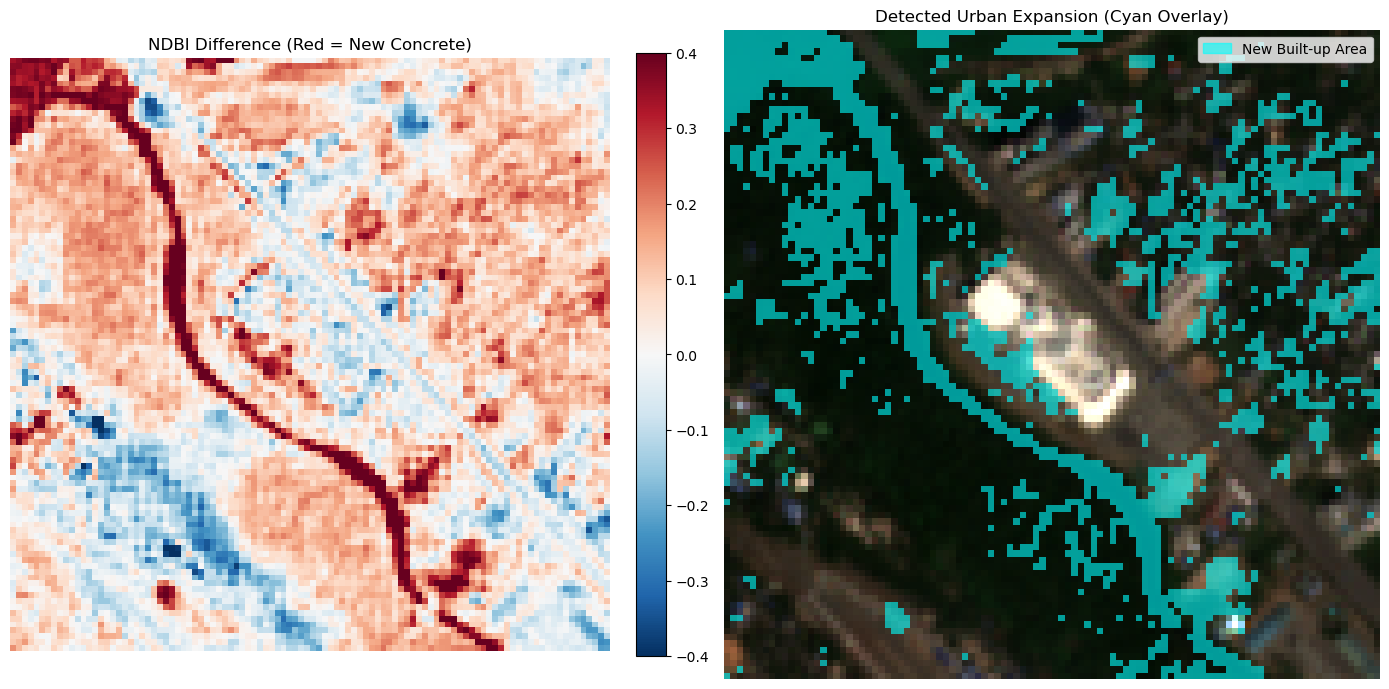

In [9]:
# --- SECTION 4: OPTICAL CHANGE DETECTION (NDBI) ---

def calculate_ndbi(ds):
    # NDBI = (SWIR - NIR) / (SWIR + NIR)
    swir = ds["B11"].astype(float)
    nir = ds["B08"].astype(float)
    
    denominator = swir + nir
    denominator = np.where(denominator == 0, 0.0001, denominator)
    return (swir - nir) / denominator

# Calculate
ndbi_2017 = calculate_ndbi(s2_ds_2017).squeeze()
ndbi_2024 = calculate_ndbi(s2_ds_2024).squeeze()
ndbi_diff = ndbi_2024 - ndbi_2017

# Threshold for "New Buildup"
optical_buildup_mask = np.where(ndbi_diff > 0.15, 1, 0)

# Visualization Setup
# Create True Color Background
rgb_2024 = np.stack([s2_ds_2024["B04"].squeeze(), 
                     s2_ds_2024["B03"].squeeze(), 
                     s2_ds_2024["B02"].squeeze()], axis=-1)
rgb_2024 = (rgb_2024 - np.nanmin(rgb_2024)) / (np.nanmax(rgb_2024) - np.nanmin(rgb_2024))
rgb_2024 = np.clip(rgb_2024 * 3.0, 0, 1) # Brighten

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# 1. Raw Difference
diff_plot = ax[0].imshow(ndbi_diff, cmap="RdBu_r", vmin=-0.4, vmax=0.4)
ax[0].set_title("NDBI Difference (Red = New Concrete)")
plt.colorbar(diff_plot, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].axis('off')

# 2. Identified Change Overlay
ax[1].imshow(rgb_2024)
colored_mask_opt = np.zeros((optical_buildup_mask.shape[0], optical_buildup_mask.shape[1], 4))
colored_mask_opt[optical_buildup_mask == 1] = [0, 1, 1, 0.6] # Cyan
ax[1].imshow(colored_mask_opt)
ax[1].set_title("Detected Urban Expansion (Cyan Overlay)")
ax[1].axis('off')

cyan_patch = mpatches.Patch(color='cyan', alpha=0.6, label='New Built-up Area')
ax[1].legend(handles=[cyan_patch], loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "optical_buildup_change.png"))
plt.show()

SAR change detection

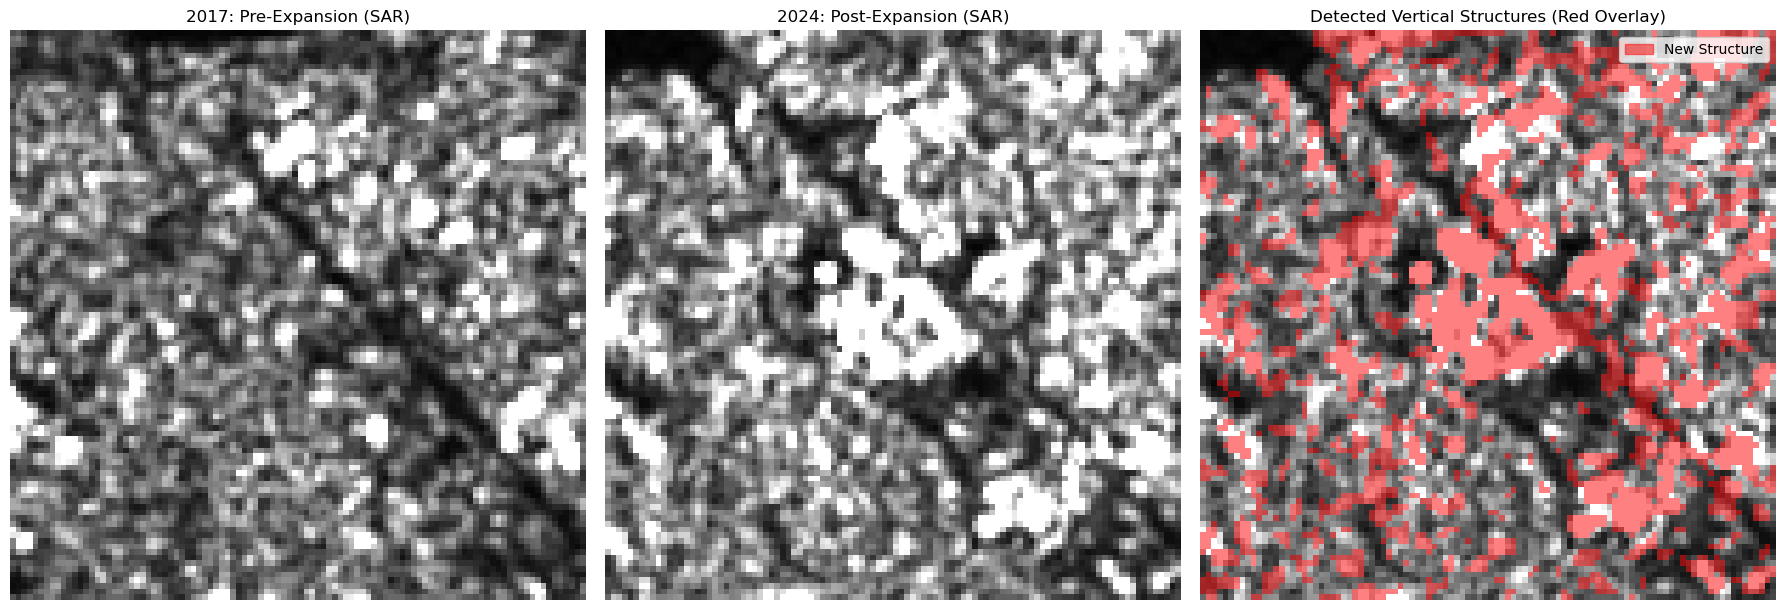

All Analysis Complete. Check output folder.


In [10]:
# --- SECTION 5: SAR CHANGE DETECTION (LOG-RATIO) ---

# Prepare Data
vv_2017 = s1_ds_2017["vv"].squeeze().astype(float)
vv_2024 = s1_ds_2024["vv"].squeeze().astype(float)

# Log Ratio: log(Image2 / Image1)
log_ratio = np.log10(vv_2024 / vv_2017)

# Thresholding for Urban Change (e.g., > 0.25)
sar_change_mask = np.where(log_ratio > 0.25, 1, 0)

# Visualization
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# 1. Pre-Event
ax[0].imshow(vv_2017, cmap="gray", vmin=0, vmax=0.5)
ax[0].set_title("2017: Pre-Expansion (SAR)")
ax[0].axis('off')

# 2. Post-Event
ax[1].imshow(vv_2024, cmap="gray", vmin=0, vmax=0.5)
ax[1].set_title("2024: Post-Expansion (SAR)")
ax[1].axis('off')

# 3. Change Overlay
ax[2].imshow(vv_2024, cmap="gray", vmin=0, vmax=0.5)
colored_mask_sar = np.zeros((sar_change_mask.shape[0], sar_change_mask.shape[1], 4))
colored_mask_sar[sar_change_mask == 1] = [1, 0, 0, 0.5] # Red
ax[2].imshow(colored_mask_sar)
ax[2].set_title("Detected Vertical Structures (Red Overlay)")
ax[2].axis('off')

red_patch = mpatches.Patch(color='red', alpha=0.5, label='New Structure')
ax[2].legend(handles=[red_patch], loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "sar_change_analysis.png"))
plt.show()

print("All Analysis Complete. Check output folder.")

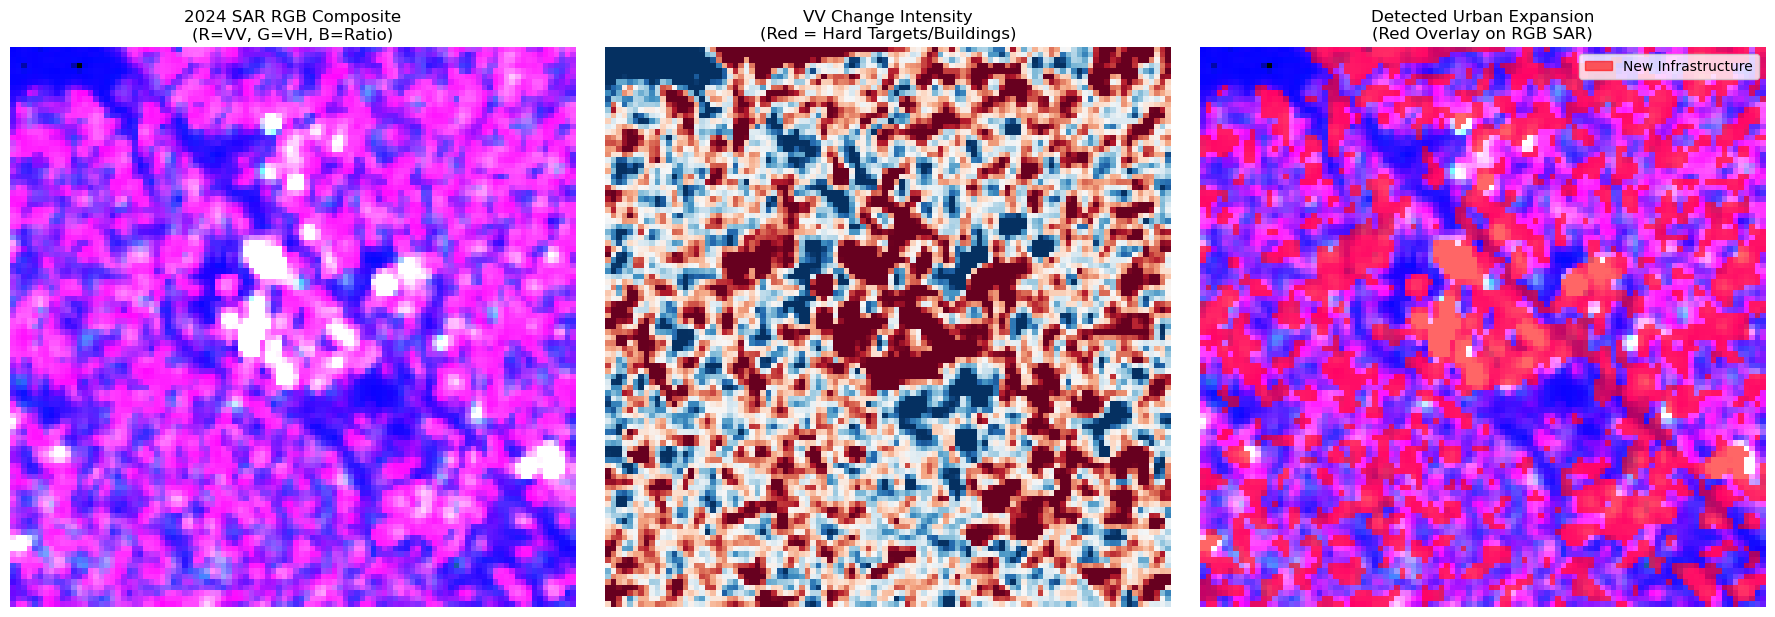

Dual-Pol Analysis Complete. Saved 'sar_dual_pol_analysis.png'.


In [ ]:
# --- SECTION 6: DUAL-POL SAR ANALYSIS (VV + VH) ---

# 1. Prepare Data for Both Polarizations
# We treat zeros as small numbers to avoid log errors
def safe_log_ratio(img_new, img_old):
    img_new = np.where(img_new <= 0, 0.001, img_new)
    img_old = np.where(img_old <= 0, 0.001, img_old)
    return np.log10(img_new / img_old)

# Extract Bands
vv_2017 = s1_ds_2017["vv"].squeeze().values
vh_2017 = s1_ds_2017["vh"].squeeze().values
vv_2024 = s1_ds_2024["vv"].squeeze().values
vh_2024 = s1_ds_2024["vh"].squeeze().values

# 2. Calculate Change for Both
change_vv = safe_log_ratio(vv_2024, vv_2017)
change_vh = safe_log_ratio(vh_2024, vh_2017)

# 3. Create a Combined "Change Magnitude"
# We average the changes to get a robust detection
total_change = (change_vv + change_vh) / 2

# Thresholding (Adjusted for sensitivity)
# VV is usually stronger for buildings, so we weight it slightly more
sar_buildup_mask = np.where(change_vv > 0.20, 1, 0) 

# --- VISUALIZATION: RGB FALSE COLOR COMPOSITE ---
# This is a professional standard for SAR visualization
# RED   = VV 2024 (Shows Structures)
# GREEN = VH 2024 (Shows Vegetation Volume)
# BLUE  = VV/VH Ratio (Texture helper)

def normalize(band):
    band = np.clip(band, 0, 0.5) # Clip bright outliers
    return (band - band.min()) / (band.max() - band.min())

# Construct the RGB image for 2024 (The "After" image)
sar_rgb = np.dstack((
    normalize(vv_2024),  # Red: Structure/Double Bounce
    normalize(vh_2024),  # Green: Vegetation/Volume
    normalize(vv_2024 / (vh_2024 + 0.01)) # Blue: Ratio
))
# Brighten the image for display
sar_rgb = np.clip(sar_rgb * 1.5, 0, 1)

# --- PLOTTING ---
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: The RGB Radar Map
ax[0].imshow(sar_rgb)
ax[0].set_title("2024 SAR RGB Composite\n(R=VV, G=VH, B=Ratio)")
ax[0].axis('off')

# Plot 2: VV Change (Specific to Buildings)
vv_plot = ax[1].imshow(change_vv, cmap="RdBu_r", vmin=-0.5, vmax=0.5)
ax[1].set_title("VV Change Intensity\n(Red = Hard Targets/Buildings)")
ax[1].axis('off')

# Plot 3: The Final Detection Overlay
ax[2].imshow(sar_rgb)
# Create Red Mask for Changes
colored_mask_sar = np.zeros((sar_buildup_mask.shape[0], sar_buildup_mask.shape[1], 4))
colored_mask_sar[sar_buildup_mask == 1] = [1, 0, 0, 0.6] # Red, 60% opacity
ax[2].imshow(colored_mask_sar)
ax[2].set_title("Detected Urban Expansion\n(Red Overlay on RGB SAR)")
ax[2].axis('off')

# Legend
red_patch = mpatches.Patch(color='red', alpha=0.6, label='New Infrastructure')
ax[2].legend(handles=[red_patch], loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "sar_dual_pol_analysis.png"))
plt.show()

print("Dual-Pol Analysis Complete. Saved 'sar_dual_pol_analysis.png'.")